In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from tqdm.notebook import tqdm

import json
import os
import time
import csv
import datetime

import matplotlib.pyplot as plt
#plt.rc('font', size=14)
import seaborn as sns
#sns.set(style='whitegrid', color_codes=True, rc={'figure.figsize':(11,8)}, font_scale=2)

In [2]:
#os.chdir('/c/Users/matth/Documents/Coding/spotify/')

In [3]:
#!pwd

### Data Importation and Processing

In [4]:
df = pd.read_csv('./final/final_newGen.csv')
df.columns

Index(['endTime', 'artistName', 'trackName', 'msPlayed', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'genre', 'clusters', 'new_gen'],
      dtype='object')

In [5]:
df['endTime']

0        2021-05-08 05:06:00
1        2021-05-10 02:22:00
2        2021-05-10 02:29:00
3        2021-05-10 02:29:00
4        2021-05-10 02:29:00
                ...         
18901    2022-05-10 23:16:00
18902    2022-05-10 23:35:00
18903    2022-05-10 23:35:00
18904    2022-05-10 23:35:00
18905    2022-05-10 23:35:00
Name: endTime, Length: 18906, dtype: object

In [6]:
df['endTime'] = pd.to_datetime(df['endTime'], format='%Y-%m-%d %H:%M:%S')
df['EST_time'] = df['endTime'] - datetime.timedelta(hours=5)

### Calendar-related Graphs

#### Prep

In [7]:
# prep
dated = df.copy()
dated = dated[['endTime','EST_time','artistName','trackName','msPlayed','genre','clusters','new_gen']]
dated['EST_time'] = pd.DatetimeIndex(dated['EST_time'])

In [8]:
dated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18906 entries, 0 to 18905
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   endTime     18906 non-null  datetime64[ns]
 1   EST_time    18906 non-null  datetime64[ns]
 2   artistName  18906 non-null  object        
 3   trackName   18906 non-null  object        
 4   msPlayed    18906 non-null  int64         
 5   genre       18906 non-null  object        
 6   clusters    18906 non-null  int64         
 7   new_gen     18906 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 1.2+ MB


In [14]:
dated['month'] = pd.DatetimeIndex(dated['EST_time']).month
dated['day'] = pd.DatetimeIndex(dated['EST_time']).day
dated['time'] = pd.DatetimeIndex(dated['EST_time']).time
dated['date'] = pd.DatetimeIndex(dated['EST_time']).date
dated['week'] = pd.DatetimeIndex(dated['EST_time']).isocalendar()['week'].values

#### 12-month Heatmap Calendar

Intensity based on the total time listened per day.

In [56]:
dated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18906 entries, 0 to 18905
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   endTime     18906 non-null  datetime64[ns]
 1   EST_time    18906 non-null  datetime64[ns]
 2   artistName  18906 non-null  object        
 3   trackName   18906 non-null  object        
 4   msPlayed    18906 non-null  int64         
 5   genre       18906 non-null  object        
 6   clusters    18906 non-null  int64         
 7   new_gen     18906 non-null  object        
 8   month       18906 non-null  int64         
 9   day         18906 non-null  int64         
 10  time        18906 non-null  object        
 11  date        18906 non-null  object        
dtypes: datetime64[ns](2), int64(4), object(6)
memory usage: 1.7+ MB


In [57]:
# summing duration played for each day
temp = dated.groupby('date').agg({'msPlayed':'sum'})
heat_12m = temp.reset_index()
#heat_12m = temp.groupby(['date'], as_index = False).agg({'counts':'max','clusters':'first'})

In [58]:
heat_12m['date'] = pd.to_datetime(heat_12m['date'], format='%Y-%m-%d')

In [59]:
from plotly_calplot import calplot

fig = calplot(
         heat_12m,
         x="date",
         y="msPlayed"
)

In [60]:
fig.write_image("./12m_heatmap.jpeg")

#### 12-month Cluster Calendar

Calendar displaying the primary cluster for each day across months

In [61]:
# most listened to new_gen for each day
temp = pd.DataFrame(dated.groupby('date')['clusters'].value_counts())
temp.rename(columns={"clusters": "counts"},inplace=True)
temp.reset_index(inplace=True)
cluster_12m = temp.groupby(['date'], as_index = False).agg({'counts':'max','clusters':'first'})

In [62]:
cluster_12m.drop('counts',axis=1,inplace=True)
cluster_12m['date'] = pd.to_datetime(cluster_12m['date'], format='%Y-%m-%d')

In [63]:
from plotly_calplot import calplot


fig = calplot(
         cluster_12m,
         x="date",
         y="clusters"
)

In [64]:
import plotly.io as pio
pio.renderers.default = 'jupyterlab' # 'iframe' or 'notebook' or 'colab' or 'jupyterlab'

fig.show() # why does the image not show?

In [65]:
fig.write_image("./12m_cluster.jpeg")

#### Individual Week in Calendar Format

For each day of the week, stacked bar chart of the clusters/new genres.

In [18]:
dated['week'].value_counts().sort_values(ascending=False)[0:10]

19    1050
4      750
48     646
22     581
10     547
23     528
5      524
52     507
50     499
2      491
Name: week, dtype: Int64

In [19]:
w=10
week = dated.copy()

In [23]:
temp = week[week['week'] == w]
graph = temp.groupby(['date','new_gen']).agg({'msPlayed':'sum'})

In [24]:
temp = graph.reset_index()
c_num = len(pd.unique(temp['new_gen']))

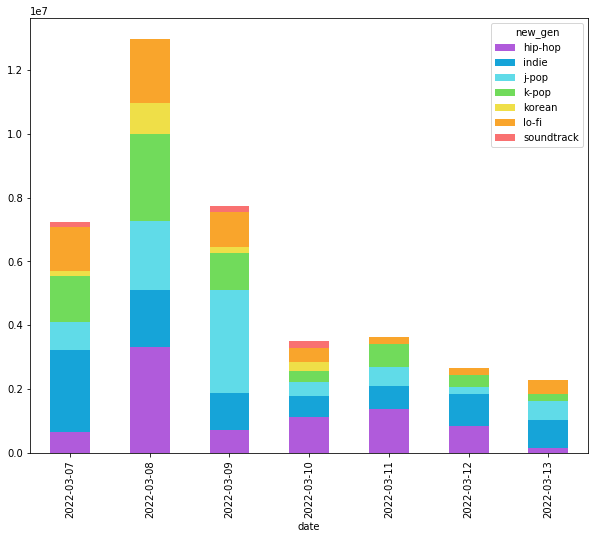

In [25]:
colors = ['#B05BDB','#16a4d8','#60dbe8','#71DB5B','#efdf48','#f9a52c','#F97171']
c = colors[:c_num]
graph['msPlayed'].unstack().plot.bar(stacked=True,figsize=(10,8), color = c)

#### Individual Day in Schedule Format

In [66]:
dated

,endTime,EST_time,artistName,trackName,msPlayed,genre,clusters,new_gen,month,day,time,date
0,2021-05-08 05:06:00,2021-05-08 00:06:00,Smallpools,Insincere,125825,indie pop,0,indie,5,8,00:06:00,2021-05-08
1,2021-05-10 02:22:00,2021-05-09 21:22:00,COIN,Turnaround,14470,indie,5,lo-fi,5,9,21:22:00,2021-05-09
2,2021-05-10 02:29:00,2021-05-09 21:29:00,Phil The Beat,Heart to Heart,790,usa,1,k-pop,5,9,21:29:00,2021-05-09
3,2021-05-10 02:29:00,2021-05-09 21:29:00,Gen Hoshino,Branko (House ver.),1380,japanese,5,lo-fi,5,9,21:29:00,2021-05-09
4,2021-05-10 02:29:00,2021-05-09 21:29:00,FINNEAS,American Cliché,2270,indie pop,3,hip-hop,5,9,21:29:00,2021-05-09
...,...,...,...,...,...,...,...,...,...,...,...,...
18901,2022-05-10 23:16:00,2022-05-10 18:16:00,League of Legends,Phoenix,197633,soundtrack,1,k-pop,5,10,18:16:00,2022-05-10
18902,2022-05-10 23:35:00,2022-05-10 18:35:00,Yoh kamiyama,生絲,1856,j-pop,1,k-pop,5,10,18:35:00,2022-05-10
18903,2022-05-10 23:35:00,2022-05-10 18:35:00,League of Legends,Legends Never Die,99035,soundtrack,1,k-pop,5,10,18:35:00,2022-05-10
18904,2022-05-10 23:35:00,2022-05-10 18:35:00,Against The Current,Wildfire - LEC Version,2453,pop punk,1,k-pop,5,10,18:35:00,2022-05-10


In [67]:
dated['date'].value_counts().sort_values(ascending=False)[0:10]

2021-05-10    367
2021-12-18    260
2022-01-11    255
2021-08-03    239
2021-06-07    236
2021-12-28    236
2021-07-13    233
2021-12-04    220
2021-08-09    201
2022-02-02    192
Name: date, dtype: int64

In [84]:
y=2021
m=12
d=28

spec_date = datetime.date(year=y,month=m,day=d) #day that the user would select

In [81]:
day = dated.copy()
day['hour'] = pd.to_datetime(day['time'].astype(str)).dt.hour #day['time'].dt.hour

In [94]:
temp = day[day['date'].isin([spec_date,datetime.date(year=y,month=m,day=d+1)])]
temp = temp[((temp['day'] == d) & (temp['hour']>=7))|((temp['day'] == d+1) & (temp['hour']<7))]
graph = temp.groupby(['hour','new_gen']).agg({'msPlayed':'sum'})

In [121]:
temp = graph.reset_index()
c_num = len(pd.unique(temp['new_gen']))

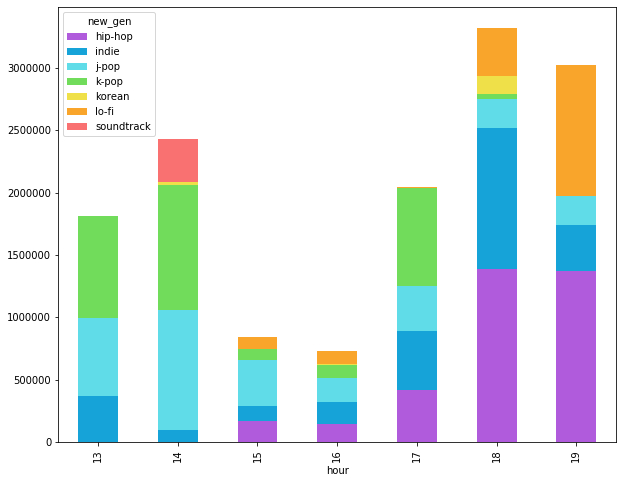

In [133]:
colors = ['#B05BDB','#16a4d8','#60dbe8','#71DB5B','#efdf48','#f9a52c','#F97171']
c = colors[:c_num]
graph['msPlayed'].unstack().plot.bar(stacked=True,figsize=(10,8), color = c)

### Variable User Inputs

This section is meant to create methods which will allow us to take in various user inputs i.e. dates or weeks that may not be in the dataset.

In [28]:
len(dated['week'].unique()) # all weeks present

52

In [30]:
len(dated['date'].unique()) # not all dates present

330